In [48]:
import sys
import time
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../lib')
import utils

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def build_X_matrix_BNT(BNT_matrix):
    """
    Builds the X matrix for the BNT transform, according to eq.
    :param BNT_matrix:
    :return:
    """
    X = {}
    delta_kron = np.eye(BNT_matrix.shape[0])
    X['L', 'L'] = np.einsum('ae, bf -> aebf', BNT_matrix, BNT_matrix)
    X['G', 'G'] = np.einsum('ae, bf -> aebf', delta_kron, delta_kron)
    X['G', 'L'] = np.einsum('ae, bf -> aebf', delta_kron, BNT_matrix)
    X['L', 'G'] = np.einsum('ae, bf -> aebf', BNT_matrix, delta_kron)
    return X


def cov_BNT_transform(cov_noBNT_6D, X_dict, probe_A, probe_B, probe_C, probe_D, optimize=True):
    """same as above, but only for one probe (i.e., LL or GL: GG is not modified by the BNT)"""
    # todo it's nicer if you sandwitch the covariance, maybe? That is, X cov X instead of X X cov
    cov_BNT_6D = np.einsum('aebf, cgdh, LMefgh -> LMabcd', X_dict[probe_A, probe_B], X_dict[probe_C, probe_D],
                           cov_noBNT_6D, optimize=optimize)
    return cov_BNT_6D


def cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict, optimize=True):
    """in np.einsum below, L and M are the ell1, ell2 indices, which are not touched by the BNT transform"""

    cov_3x2pt_BNT_dict_10D = {}

    for probe_A, probe_B, probe_C, probe_D in cov_3x2pt_10D_dict.keys():
        cov_3x2pt_BNT_dict_10D[probe_A, probe_B, probe_C, probe_D] = \
            cov_BNT_transform(cov_3x2pt_10D_dict[probe_A, probe_B, probe_C, probe_D], X_dict,
                              probe_A, probe_B, probe_C, probe_D, optimize=optimize)

    return cov_3x2pt_BNT_dict_10D


def cl_BNT_transform(cl_3D, BNT_matrix, probe_A, probe_B):
    assert cl_3D.ndim == 3, 'cl_3D must be 3D'
    assert BNT_matrix.ndim == 2, 'BNT_matrix must be 2D'
    assert cl_3D.shape[1] == BNT_matrix.shape[0], 'the number of ell bins in cl_3D and BNT_matrix must be the same'

    BNT_transform_dict = {
        'L': BNT_matrix,
        'G': np.eye(BNT_matrix.shape[0]),
    }

    cl_3D_BNT = np.zeros(cl_3D.shape)
    for ell_idx in range(cl_3D.shape[0]):
        cl_3D_BNT[ell_idx, :, :] = BNT_transform_dict[probe_A] @ \
                                   cl_3D[ell_idx, :, :] @ \
                                   BNT_transform_dict[probe_B].T

    return cl_3D_BNT


def cl_BNT_transform_3x2pt(cl_3x2pt_5D, BNT_matrix):
    """wrapper function to quickly implement the cl (or derivatives) BNT transform for the 3x2pt datavector"""

    cl_3x2pt_5D_BNT = np.zeros(cl_3x2pt_5D.shape)
    cl_3x2pt_5D_BNT[0, 0, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[0, 0, :, :, :], BNT_matrix, 'L', 'L')
    cl_3x2pt_5D_BNT[0, 1, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[0, 1, :, :, :], BNT_matrix, 'L', 'G')
    cl_3x2pt_5D_BNT[1, 0, :, :, :] = cl_BNT_transform(cl_3x2pt_5D[1, 0, :, :, :], BNT_matrix, 'G', 'L')
    cl_3x2pt_5D_BNT[1, 1, :, :, :] = cl_3x2pt_5D[1, 1, :, :, :]  # no need to transform the GG part

    return cl_3x2pt_5D_BNT

In [51]:
# ! settings
survey_area_ISTF = 15_000  # deg^2
deg2_in_sphere = 41252.96  # deg^2 in a spere

fsky = survey_area_ISTF / deg2_in_sphere
zbins = 10
nbl = 20
n_gal = 30
sigma_eps = 0.3
EP_or_ED = 'EP'
GL_or_LG = 'GL'
triu_tril = 'triu'
row_col_major = 'row-major'
probe_ordering = [['L', 'L'], [GL_or_LG[0], GL_or_LG[1]], ['G', 'G']]
block_index = 'ell'
n_probes = 2
input_folder = 'march_2023'

In [52]:
ind = utils.build_full_ind(triu_tril, row_col_major, zbins)
zpairs_auto, zpairs_cross, zpairs_3x2pt = utils.get_zpairs(zbins)

In [53]:
ind_auto = ind[:zpairs_auto, :]
ind_cross = ind[zpairs_auto:zpairs_auto + zpairs_cross, :]

In [54]:
cl_LL_3D = np.load(f'../input/march_2023/Cl_LL.npy')
cl_GL_3D = np.load(f'../input/march_2023/Cl_GL.npy')
cl_GG_3D = np.load(f'../input/march_2023/Cl_GG.npy')

ell_values = np.load(f'../input/ell_values.npy')
delta_ell = np.load(f'../input/delta_ells.npy')
BNT_matrix = np.genfromtxt('../input/BNT_matrix.txt')

## Check 

In [55]:
cl_3x2pt_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_5D[0, 0, :, :, :] = cl_LL_3D
cl_3x2pt_5D[0, 1, :, :, :] = cl_GL_3D.transpose(0, 2, 1)
cl_3x2pt_5D[1, 0, :, :, :] = cl_GL_3D
cl_3x2pt_5D[1, 1, :, :, :] = cl_GG_3D

In [56]:
# create a noise with dummy axis for ell, to have the same shape as cl_3x2pt_5D
noise_3x2pt_4D = utils.build_noise(zbins, n_probes, sigma_eps2=sigma_eps ** 2, ng=n_gal, EP_or_ED=EP_or_ED)
noise_3x2pt_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
for probe_A in (0, 1):
    for probe_B in (0, 1):
        for ell_idx in range(nbl):
            noise_3x2pt_5D[probe_A, probe_B, ell_idx, :, :] = noise_3x2pt_4D[probe_A, probe_B, ...]

# 5d versions of auto.probe data and spectra
cl_LL_5D = cl_LL_3D[np.newaxis, np.newaxis, ...]
noise_LL_5D = noise_3x2pt_5D[0, 0, ...][np.newaxis, np.newaxis, ...]

### Regular (no BNT) covariance

In [57]:
# compute
cov_WL_6D = utils.covariance_einsum(cl_LL_5D, noise_LL_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]
cov_3x2pt_10D_arr = utils.covariance_einsum(cl_3x2pt_5D, noise_3x2pt_5D, fsky, ell_values, delta_ell)

# reshape to 4D
cov_WL_4D = utils.cov_6D_to_4D(cov_WL_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_WL_2D = utils.cov_4D_to_2D(cov_WL_4D, block_index=block_index)
cov_3x2pt_2D = utils.cov_4D_to_2D(cov_3x2pt_4D, block_index=block_index)
cov_3x2pt_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_4D, nbl, zbins)

the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


### BNT covariance

In [58]:
# transform (I need the 3x2pt dictionary for the BNT covariance)
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_WL_BNTcov_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')
cov_3x2pt_BNTcov_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)

# reshape to 4D
cov_WL_BNTcov_4D = utils.cov_6D_to_4D(cov_WL_BNTcov_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNTcov_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNTcov_10D_dict, probe_ordering, nbl, zbins, ind.copy(),
                                                  GL_or_LG)
# reshape to 2D
cov_WL_BNTcov_2D = utils.cov_4D_to_2D(cov_WL_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2D = utils.cov_4D_to_2D(cov_3x2pt_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNTcov_4D, nbl, zbins)

the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/bin/../lib/utils.py:126: RuntimeWarning: divide by zero encountered in log10
  A_toplot, B_toplot = np.log10(A), np.log10(B)
/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/bin/../lib/utils.py:126: RuntimeWarning: invalid value encountered in log10
  A_toplot, B_toplot = np.log10(A), np.log10(B)


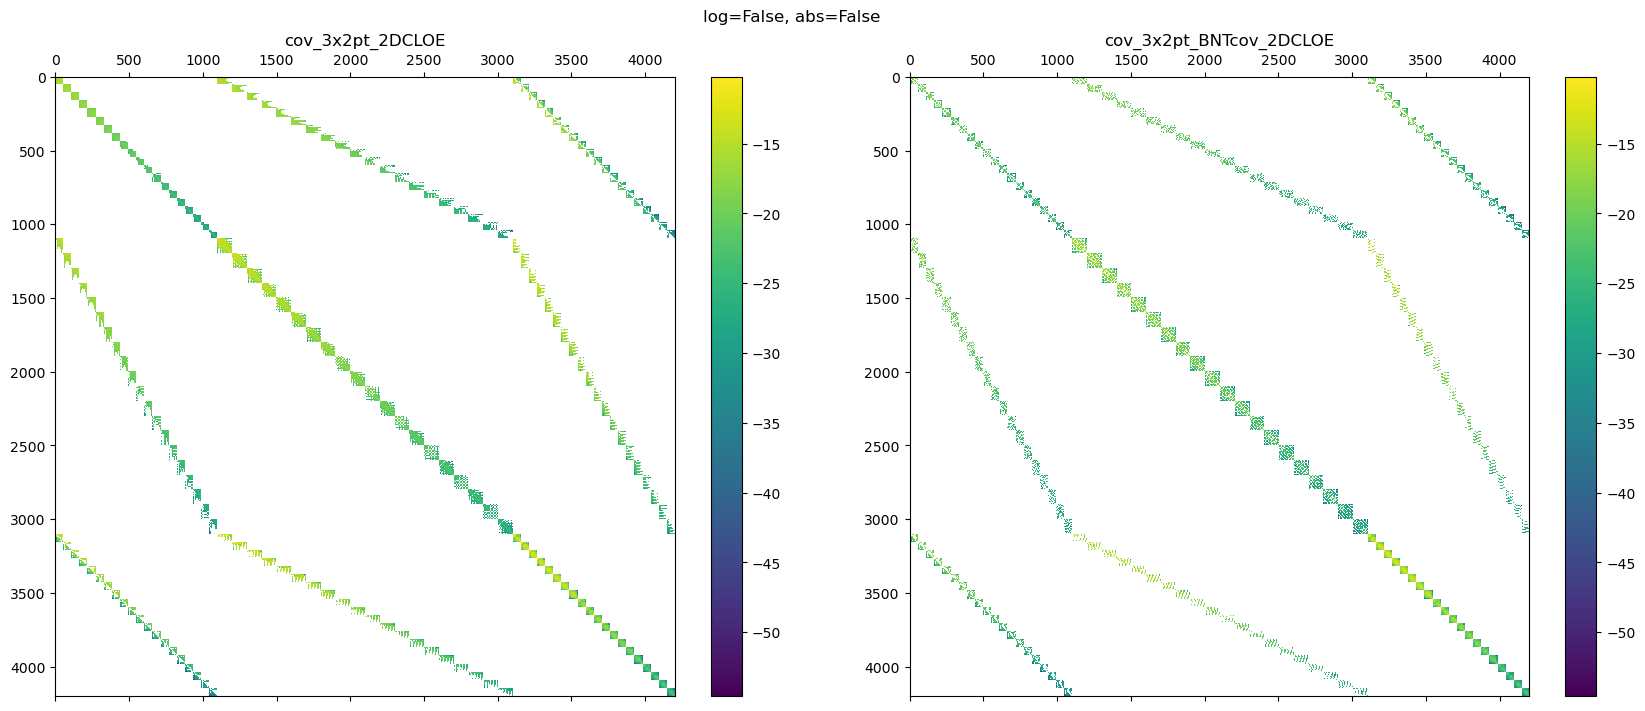

Are A and B different by less than 5.0%? ❌ 
Max discrepancy: inf%;
Number of elements with discrepancy > 5.0%: 767973
Fraction of elements with discrepancy > 5.0%: 0.04354


/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/bin/../lib/utils.py:46: RuntimeWarning: divide by zero encountered in true_divide
  diff = (array_1 / array_2 - 1) * 100
/Users/davide/Documents/Lavoro/Programmi/cov_for_santi/bin/../lib/utils.py:46: RuntimeWarning: invalid value encountered in true_divide
  diff = (array_1 / array_2 - 1) * 100


In [59]:
utils.compare_arrays(cov_3x2pt_2DCLOE, cov_3x2pt_BNTcov_2DCLOE, 'cov_3x2pt_2DCLOE', 'cov_3x2pt_BNTcov_2DCLOE',
                  plot_array=True, log_array=True)

### BNT covariance with BNT cls

In [60]:
# transform cls AND NOISE
cl_LL_BNT_3D = cl_BNT_transform(cl_LL_3D, BNT_matrix, 'L', 'L')
noise_LL_BNT_3D = cl_BNT_transform(noise_LL_5D[0, 0, ...], BNT_matrix, 'L', 'L')
cl_3x2pt_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_5D, BNT_matrix)
noise_3x2pt_BNT_5D = cl_BNT_transform_3x2pt(noise_3x2pt_5D, BNT_matrix)

# compute cov
cl_LL_BNT_5D = cl_LL_BNT_3D[np.newaxis, np.newaxis, ...]
noise_LL_BNT_5D = noise_LL_BNT_3D[np.newaxis, np.newaxis, ...]
cov_WL_BNTcl_6D = utils.covariance_einsum(cl_LL_BNT_5D, noise_LL_BNT_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]
cov_3x2pt_BNTcl_10D_arr = utils.covariance_einsum(cl_3x2pt_BNT_5D, noise_3x2pt_BNT_5D, fsky, ell_values, delta_ell)

In [61]:
# reshape to 4D
cov_WL_BNTcl_4D = utils.cov_6D_to_4D(cov_WL_BNTcl_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNTcl_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_BNTcl_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_BNTcl_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNTcl_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_WL_BNTcl_2D = utils.cov_4D_to_2D(cov_WL_BNTcl_4D, block_index=block_index)
cov_3x2pt_BNTcl_2D = utils.cov_4D_to_2D(cov_3x2pt_BNTcl_4D, block_index=block_index)
cov_3x2pt_BNTcl_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNTcl_4D, nbl, zbins)

the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


## BNT cov vs. cov with BNT cls
There is a very small number of outliers with a large discrepancy (barely visible in the plot on the r.h.s.)

diff_AB and diff_BA have a relative difference of more than 1%
plotting the *absolute value* of the difference only where it is below the given threshold (5%)


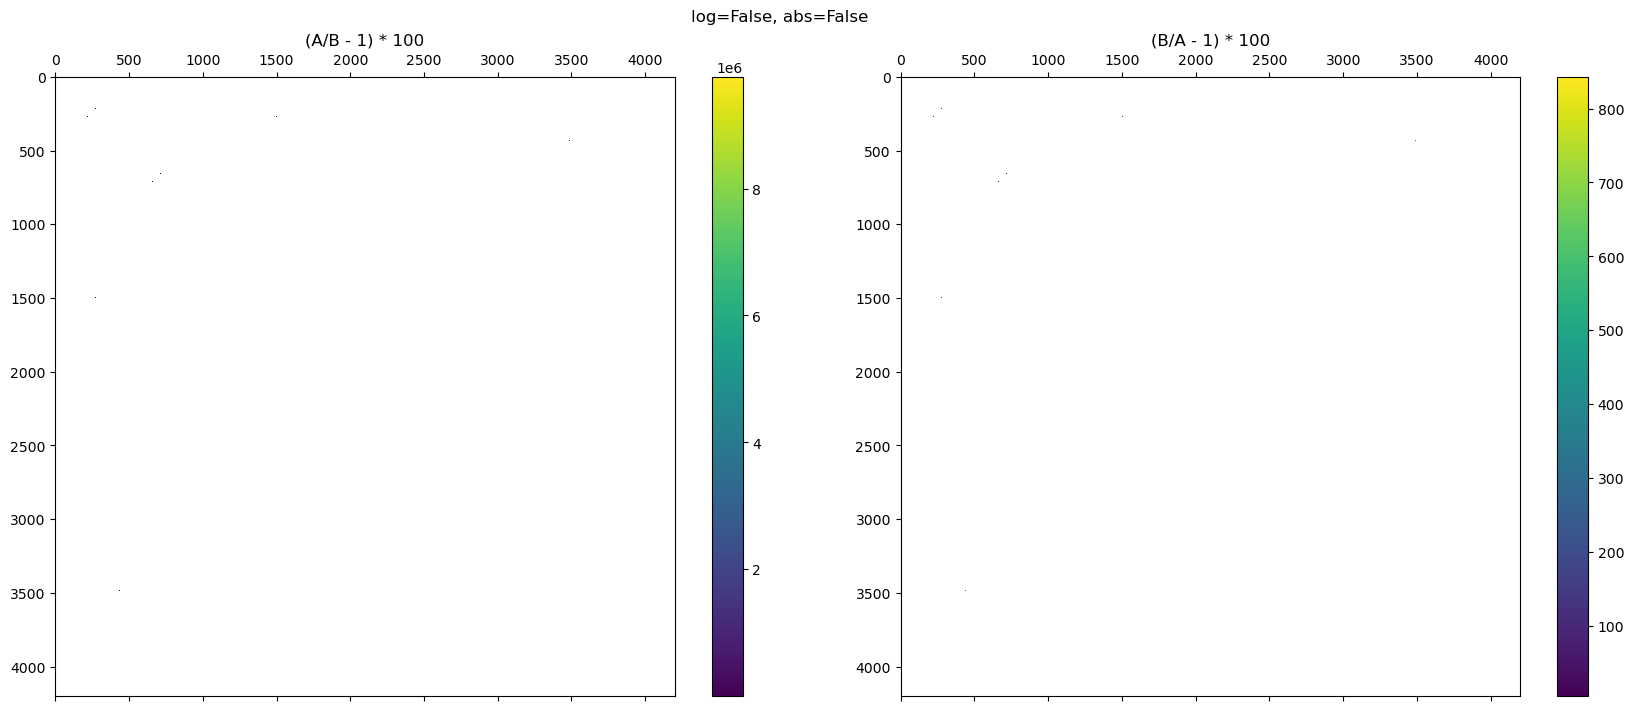

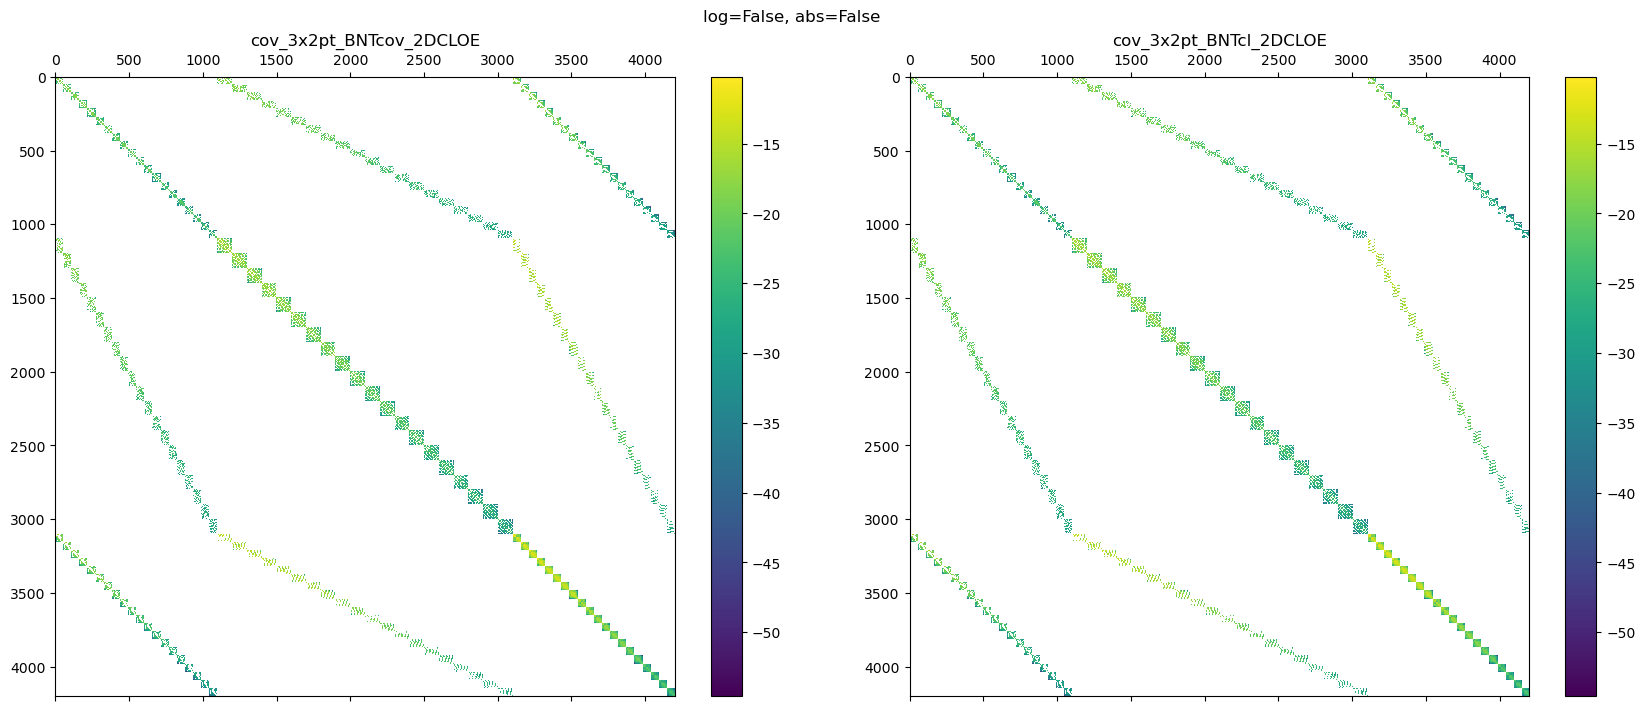

Are A and B different by less than 5%? ❌ 
Max discrepancy: 9763543.74%;
Number of elements with discrepancy > 5%: 276
Fraction of elements with discrepancy > 5%: 0.00002


In [62]:
utils.compare_arrays(cov_3x2pt_BNTcov_2DCLOE, cov_3x2pt_BNTcl_2DCLOE, 'cov_3x2pt_BNTcov_2DCLOE', 'cov_3x2pt_BNTcl_2DCLOE',
                  plot_array=True, log_array=True,
                  plot_diff=True, log_diff=False, plot_diff_threshold=5)

In [63]:
np.savez_compressed('../output/cov_3x2pt_2D.npz', cov_3x2pt_2D)
np.savez_compressed('../output/cov_3x2pt_BNTcov_2D.npz', cov_3x2pt_BNTcov_2D)

# format used by CLOE 
np.savez_compressed('../output/cov_3x2pt_2DCLOE.npz', cov_3x2pt_2DCLOE)
np.savez_compressed('../output/cov_3x2pt_BNTcov_2DCLOE.npz', cov_3x2pt_BNTcov_2DCLOE)

# Test $\chi^2$

In [92]:
# import the data and theory vectors
cl_LL_theory_3D = np.load('../input/test_chi2/cloetheory_Cl_LL_3d.npy')
cl_GL_theory_3D = np.load('../input/test_chi2/cloetheory_Cl_GL_3d.npy')
cl_GG_theory_3D = np.load('../input/test_chi2/cloetheory_Cl_GG_3d.npy')

cl_LL_data_3D = np.load('../input/test_chi2/cloedata_Cl_LL_3d.npy') 
cl_GL_data_3D = np.load('../input/test_chi2/cloedata_Cl_GL_3d.npy')
cl_GG_data_3D = np.load('../input/test_chi2/cloedata_Cl_GG_3d.npy')

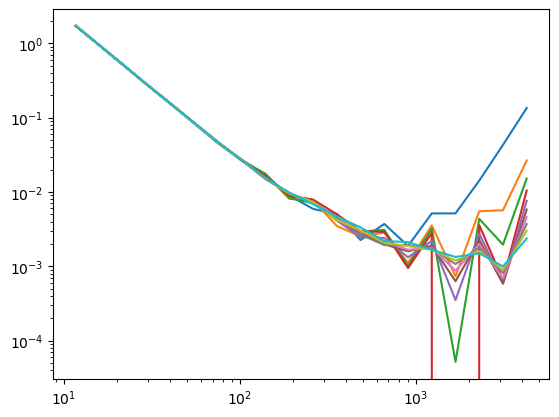

In [93]:
for zi in range(zbins):
    plt.loglog(ell_values,( cl_LL_data_3D[:, zi, zi]/cl_LL_theory_3D[:, zi, zi] - 1)*100, label='data')

In [94]:
# create 3x2pt data  vectors
cl_3x2pt_theory_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_theory_5D[0, 0, :, :, :] = cl_LL_theory_3D
cl_3x2pt_theory_5D[0, 1, :, :, :] = cl_GL_theory_3D.transpose(0, 2, 1)
cl_3x2pt_theory_5D[1, 0, :, :, :] = cl_GL_theory_3D
cl_3x2pt_theory_5D[1, 1, :, :, :] = cl_GG_theory_3D

cl_3x2pt_data_5D = np.zeros((n_probes, n_probes, nbl, zbins, zbins))
cl_3x2pt_data_5D[0, 0, :, :, :] = cl_LL_data_3D
cl_3x2pt_data_5D[0, 1, :, :, :] = cl_GL_data_3D.transpose(0, 2, 1)
cl_3x2pt_data_5D[1, 0, :, :, :] = cl_GL_data_3D
cl_3x2pt_data_5D[1, 1, :, :, :] = cl_GG_data_3D

# reshape to compute WL-only covariance
cl_LL_theory_5D = cl_3x2pt_theory_5D[0, 0, :, :, :][None, None, ...]
cl_LL_data_5D = cl_3x2pt_data_5D[0, 0, :, :, :][None, None, ...]
noise_LL_5D = noise_3x2pt_5D[0, 0, :, :, :][None, None, ...]

In [95]:
# BNT transform data and theory vectors
cl_3x2pt_theory_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_theory_5D, BNT_matrix)
cl_3x2pt_data_BNT_5D = cl_BNT_transform_3x2pt(cl_3x2pt_data_5D, BNT_matrix)

In [96]:
# compute data covariance
cov_3x2pt_10D_arr = utils.covariance_einsum(cl_3x2pt_data_5D, noise_3x2pt_5D, fsky, ell_values, delta_ell)
cov_WL_6D = utils.covariance_einsum(cl_LL_data_5D, noise_LL_5D, fsky, ell_values, delta_ell)[0, 0, 0, 0, ...]

# BNT transform covariance
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_3x2pt_10D_dict = utils.cov_10D_array_to_dict(cov_3x2pt_10D_arr)  # not important, equivalent to the array above
cov_3x2pt_BNT_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)
cov_WL_BNT_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')

# reshape to 4D
cov_3x2pt_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_3x2pt_BNT_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNT_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)
cov_WL_4D = utils.cov_6D_to_4D(cov_WL_6D, nbl, zpairs_auto, ind_auto)
cov_WL_BNT_4D = utils.cov_6D_to_4D(cov_WL_BNT_6D, nbl, zpairs_auto, ind_auto)

# reshape to 2D
cov_3x2pt_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_4D, nbl, zbins)
cov_3x2pt_BNT_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNT_4D, nbl, zbins)
cov_WL_2D = utils.cov_4D_to_2D(cov_WL_4D, block_index=block_index)
cov_WL_BNT_2D = utils.cov_4D_to_2D(cov_WL_BNT_4D, block_index=block_index)


the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 
the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


In [97]:
# utils.compare_arrays(cov_3x2pt_2DCLOE, cov_3x2pt_BNT_2DCLOE, 
#                      'cov_3x2pt_2DCLOE', 'cov_3x2pt_BNT_2DCLOE',
#                     plot_array=True, log_array=True,
#                   plot_diff=False, log_diff=False, plot_diff_threshold=5)

In [98]:
# flatten the 3x2pt theory and data vectors (flatten first, then concatenate the probes in this covariance ordering)
cl_LL_theory_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')
cl_GL_theory_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell')
cl_GG_theory_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')

cl_LL_data_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')
cl_GL_data_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell')
cl_GG_data_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')

cl_LL_theory_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')
cl_GL_theory_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell')
cl_GG_theory_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_theory_BNT_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')

cl_LL_data_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_BNT_5D[0, 0, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')
cl_GL_data_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_BNT_5D[1, 0, :, :, :], ind_cross, is_auto_spectrum=False, block_index='ell')
cl_GG_data_BNT_1D = utils.Cl_3D_to_1D(cl_3x2pt_data_BNT_5D[1, 1, :, :, :], ind_auto, is_auto_spectrum=True, block_index='ell')

In [101]:
# concatenate
cl_3x2pt_theory_1D = np.concatenate((cl_LL_theory_1D, cl_GL_theory_1D, cl_GG_theory_1D))
cl_3x2pt_data_1D = np.concatenate((cl_LL_data_1D, cl_GL_data_1D, cl_GG_data_1D))

cl_3x2pt_theory_BNT_1D = np.concatenate((cl_LL_theory_BNT_1D, cl_GL_theory_BNT_1D, cl_GG_theory_BNT_1D))
cl_3x2pt_data_BNT_1D = np.concatenate((cl_LL_data_BNT_1D, cl_GL_data_BNT_1D, cl_GG_data_BNT_1D))

In [103]:
# BNT transform covariance
X_dict = build_X_matrix_BNT(BNT_matrix)
cov_WL_BNTcov_6D = cov_BNT_transform(cov_WL_6D, X_dict, 'L', 'L', 'L', 'L')
cov_3x2pt_BNTcov_10D_dict = cov_3x2pt_BNT_transform(cov_3x2pt_10D_dict, X_dict)

# reshape to 4D
cov_WL_BNTcov_4D = utils.cov_6D_to_4D(cov_WL_BNTcov_6D, nbl, zpairs_auto, ind[:zpairs_auto])
cov_3x2pt_BNTcov_4D = utils.cov_3x2pt_dict_10D_to_4D(cov_3x2pt_BNTcov_10D_dict, probe_ordering, nbl, zbins, ind.copy(), GL_or_LG)

# reshape to 2D
cov_WL_BNTcov_2D = utils.cov_4D_to_2D(cov_WL_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2D = utils.cov_4D_to_2D(cov_3x2pt_BNTcov_4D, block_index=block_index)
cov_3x2pt_BNTcov_2DCLOE = utils.cov_4D_to_2DCLOE_3x2pt(cov_3x2pt_BNTcov_4D, nbl, zbins)

the probe ordering (LL, LG/GL, GG) is hardcoded, this function won't work with other combinations (but it will work both for LG and GL) 


In [104]:
# compute chi2
chi2_3x2pt_noBNT = (cl_3x2pt_data_1D - cl_3x2pt_theory_1D) @ np.linalg.inv(cov_3x2pt_2DCLOE) @ (cl_3x2pt_data_1D - cl_3x2pt_theory_1D)
chi2_3x2pt_BNT = (cl_3x2pt_data_BNT_1D - cl_3x2pt_theory_BNT_1D) @ np.linalg.inv(cov_3x2pt_BNT_2DCLOE) @ (cl_3x2pt_data_BNT_1D - cl_3x2pt_theory_BNT_1D)

chi2_LL_noBNT = (cl_LL_data_1D - cl_LL_theory_1D) @ np.linalg.inv(cov_WL_2D) @ (cl_LL_data_1D - cl_LL_theory_1D)
chi2_LL_BNT = (cl_LL_data_BNT_1D - cl_LL_theory_BNT_1D) @ np.linalg.inv(cov_WL_BNT_2D) @ (cl_LL_data_BNT_1D - cl_LL_theory_BNT_1D)

In [105]:
print('chi squared 3x2pt, no BNT = ', chi2_3x2pt_noBNT)
print('chi squared 3x2pt, BNT = ', chi2_3x2pt_BNT)
print('chi squared LL, no BNT = ', chi2_LL_noBNT)
print('chi squared LL, BNT = ', chi2_LL_BNT)

chi squared 3x2pt, no BNT =  5.6529562341577515
chi squared 3x2pt, BNT =  5.652956234165786
chi squared LL, no BNT =  0.023867421689969893
chi squared LL, BNT =  0.023867421689970032
